# VWBR (finra_buy_volume_z) Heatmap

Visualize FINRA buy volume z-scores across multiple ticker categories.

**Color scheme**: Purple (negative z) <- Black (neutral) -> Neon Green (positive z)

In [ ]:
# =============================================================================
# USER CONFIGURATION
# =============================================================================

# Date range for heatmap
START_DATE = "2025-10-08"
END_DATE = "2026-01-05"

# Ticker Types: ["SECTOR", "SUMMARY", "GLOBAL", "COMMODITIES", "MAG8", "SPECULATIVE", "CRYPTO"] or ["ALL"]
TICKER_TYPES = ["SECTOR", "SUMMARY", "GLOBAL", "COMMODITIES", "MAG8"]

# View Mode: "indices" (main ETF/index only) or "constituents" (expand to holdings)
VIEW_MODE = "indices"  # or "constituents"

# Z-Scale Mode: "global" (vmin/vmax across all tickers) or "per_row" (vmin/vmax per ticker row)
Z_SCALE_MODE = "global"

# Cell size in inches (for square cells)
CELL_SIZE = 0.15

# Clustering options
ENABLE_CLUSTERING = True   # Toggle Y-axis clustering on/off
SHOW_DENDROGRAM = True     # Show dendrogram tree on left side of heatmap

# =============================================================================
# IMPORTS
# =============================================================================

import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize, TwoSlopeNorm
from matplotlib.patches import Rectangle
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
import importlib.util
from pathlib import Path
from datetime import datetime

# Clustering imports
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from scipy.spatial.distance import squareform

print("Configuration loaded.")

In [11]:
# =============================================================================
# CELL 2: TICKER DICTIONARY LOADING
# =============================================================================

def _load_ticker_dictionary():
    """Load ticker_dictionary.py dynamically from known locations."""
    candidates = [
        Path.cwd() / "ticker_dictionary.py",
        Path.cwd() / "Special_tools" / "ticker_dictionary.py",
        Path.cwd() / "darkpool" / "Special_tools" / "ticker_dictionary.py",
    ]
    
    for path in candidates:
        if path.exists():
            spec = importlib.util.spec_from_file_location("ticker_dictionary", path)
            if spec and spec.loader:
                module = importlib.util.module_from_spec(spec)
                spec.loader.exec_module(module)
                print(f"Loaded ticker dictionary from: {path}")
                return module
    raise FileNotFoundError(f"Could not find ticker_dictionary.py in: {candidates}")

# Load the module
ticker_dict = _load_ticker_dictionary()

# Extract data structures
SECTOR_ZOOM_MAP = getattr(ticker_dict, 'SECTOR_ZOOM_MAP', {})
SPECULATIVE_TICKERS = getattr(ticker_dict, 'SPECULATIVE_TICKERS', [])
CRYPTO_TICKERS = getattr(ticker_dict, 'CRYPTO_TICKERS', [])

# Mapping from user-friendly names to SECTOR_ZOOM_MAP keys
TYPE_TO_ZOOM_KEY = {
    "SECTOR": "SECTOR_CORE",
    "SUMMARY": "SECTOR_SUMMARY",
    "GLOBAL": "GLOBAL_MACRO",
    "COMMODITIES": "COMMODITIES",
    "MAG8": "MAG8",
}

# Synthetic parent tickers that don't exist as real tradeable tickers in the database
# These will always be expanded to constituents, even in "indices" mode
SYNTHETIC_PARENTS = {"MAG8"}

def build_ticker_list(ticker_types, view_mode):
    """
    Build list of tickers based on selected types and view mode.
    
    Returns:
        tickers: List of ticker symbols to query
        tickers_meta: Dict with category and parent info for each ticker
    """
    # Normalize "ALL" to full list
    if "ALL" in ticker_types:
        ticker_types = ["SECTOR", "SUMMARY", "GLOBAL", "COMMODITIES", "MAG8", "SPECULATIVE", "CRYPTO"]
    
    tickers = []
    tickers_meta = {}  # ticker -> {category, parent, order}
    order = 0
    
    for ttype in ticker_types:
        if ttype in ["SPECULATIVE", "CRYPTO"]:
            # These are flat lists
            flat_list = SPECULATIVE_TICKERS if ttype == "SPECULATIVE" else CRYPTO_TICKERS
            for ticker in flat_list:
                if ticker not in tickers:
                    tickers.append(ticker)
                    tickers_meta[ticker] = {
                        "category": ttype,
                        "parent": None,
                        "order": order
                    }
                    order += 1
        elif ttype in TYPE_TO_ZOOM_KEY:
            zoom_key = TYPE_TO_ZOOM_KEY[ttype]
            if zoom_key in SECTOR_ZOOM_MAP:
                category_data = SECTOR_ZOOM_MAP[zoom_key]
                for parent_ticker, constituents in category_data.items():
                    # Check if this is a synthetic parent (not a real tradeable ticker)
                    is_synthetic = parent_ticker in SYNTHETIC_PARENTS
                    
                    if view_mode == "indices" and not is_synthetic:
                        # Real ETF/index - only add the parent ticker
                        if parent_ticker not in tickers:
                            tickers.append(parent_ticker)
                            tickers_meta[parent_ticker] = {
                                "category": ttype,
                                "parent": None,
                                "order": order
                            }
                            order += 1
                    else:
                        # Constituents mode OR synthetic parent - add all constituents
                        if not is_synthetic and parent_ticker not in tickers:
                            # Add real parent first (not for synthetic)
                            tickers.append(parent_ticker)
                            tickers_meta[parent_ticker] = {
                                "category": ttype,
                                "parent": None,
                                "is_parent": True,
                                "order": order
                            }
                            order += 1
                        # Add constituents
                        for constituent in constituents:
                            if constituent not in tickers:
                                tickers.append(constituent)
                                tickers_meta[constituent] = {
                                    "category": ttype,
                                    "parent": parent_ticker if not is_synthetic else f"({parent_ticker})",
                                    "is_parent": False,
                                    "order": order
                                }
                                order += 1
    
    print(f"Built ticker list: {len(tickers)} tickers from {ticker_types}")
    return tickers, tickers_meta

# Test
test_tickers, test_meta = build_ticker_list(TICKER_TYPES, VIEW_MODE)
print(f"Sample tickers: {test_tickers[:10]}...")

Loaded ticker dictionary from: c:\Users\fvign\Dropbox\Vscode\darkpool\Special_tools\ticker_dictionary.py
Built ticker list: 39 tickers from ['SECTOR', 'SUMMARY', 'GLOBAL', 'COMMODITIES', 'MAG8']
Sample tickers: ['XLF', 'KRE', 'XLK', 'SMH', 'XLI', 'XLY', 'XLE', 'XLV', 'XLP', 'XLU']...


In [12]:
# =============================================================================
# CELL 3: DATABASE CONNECTION
# =============================================================================

def get_db_path():
    """Find the darkpool.duckdb database using relative paths."""
    candidates = [
        Path.cwd() / "darkpool_analysis" / "data" / "darkpool.duckdb",
        Path.cwd().parent / "darkpool_analysis" / "data" / "darkpool.duckdb",
        Path.cwd() / ".." / "darkpool_analysis" / "data" / "darkpool.duckdb",
        Path.cwd() / "darkpool" / "darkpool_analysis" / "data" / "darkpool.duckdb",
    ]
    
    for path in candidates:
        resolved = path.resolve()
        if resolved.exists():
            return resolved
    
    raise FileNotFoundError(f"Could not find darkpool.duckdb in: {[str(p) for p in candidates]}")

def connect_db():
    """Connect to the DuckDB database in read-only mode."""
    db_path = get_db_path()
    print(f"Connecting to database: {db_path}")
    return duckdb.connect(str(db_path), read_only=True)

# Test connection
with connect_db() as conn:
    tables = conn.execute("SELECT table_name FROM information_schema.tables WHERE table_schema = 'main'").fetchall()
    print(f"Available tables: {[t[0] for t in tables]}")

Connecting to database: C:\Users\fvign\Dropbox\Vscode\darkpool\darkpool_analysis\data\darkpool.duckdb
Available tables: ['composite_signal', 'daily_metrics', 'finra_otc_weekly_raw', 'finra_short_daily_raw', 'index_constituent_short_agg_daily', 'lit_direction_daily', 'options_premium_daily', 'options_premium_summary', 'polygon_daily_agg_raw', 'polygon_equity_trades_raw', 'polygon_ingestion_state']


In [13]:
# =============================================================================
# CELL 4: DATA FETCHING
# =============================================================================

def fetch_heatmap_data(conn, tickers, start_date, end_date):
    """
    Fetch finra_buy_volume_z data for specified tickers and date range.
    
    Returns:
        DataFrame with tickers as rows, dates as columns, values are finra_buy_volume_z
    """
    # Build parameterized query
    placeholders = ", ".join(["?" for _ in tickers])
    query = f"""
        SELECT date, symbol, finra_buy_volume_z
        FROM daily_metrics
        WHERE symbol IN ({placeholders})
          AND date BETWEEN ? AND ?
        ORDER BY date, symbol
    """
    
    params = list(tickers) + [start_date, end_date]
    result = conn.execute(query, params).fetchdf()
    
    if result.empty:
        print(f"Warning: No data found for tickers in date range {start_date} to {end_date}")
        return pd.DataFrame()
    
    # Pivot: rows=tickers, columns=dates
    pivot = result.pivot(index='symbol', columns='date', values='finra_buy_volume_z')
    
    # Reorder rows to match input ticker order
    available_tickers = [t for t in tickers if t in pivot.index]
    missing_tickers = [t for t in tickers if t not in pivot.index]
    if missing_tickers:
        print(f"Warning: {len(missing_tickers)} tickers not found in database: {missing_tickers[:5]}...")
    
    pivot = pivot.reindex(available_tickers)
    
    print(f"Fetched data: {pivot.shape[0]} tickers x {pivot.shape[1]} days")
    return pivot

# Test fetch
with connect_db() as conn:
    test_data = fetch_heatmap_data(conn, test_tickers, START_DATE, END_DATE)
    print(f"Data shape: {test_data.shape}")
    if not test_data.empty:
        print(f"Date range: {test_data.columns.min()} to {test_data.columns.max()}")

Connecting to database: C:\Users\fvign\Dropbox\Vscode\darkpool\darkpool_analysis\data\darkpool.duckdb
Fetched data: 39 tickers x 61 days
Data shape: (39, 61)
Date range: 2025-10-08 00:00:00 to 2026-01-05 00:00:00


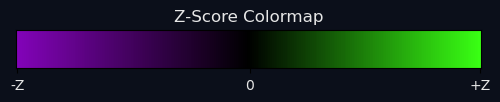

In [14]:
# =============================================================================
# CELL 5: COLOR MAPPING
# =============================================================================

# Dark theme colors
BG_COLOR = '#0b0f1a'
TEXT_COLOR = '#e6e6e6'
GRID_COLOR = '#2a2a3a'

# Diverging colormap: Purple <- Black -> Neon Green
PURPLE = '#8304B9'
BLACK = '#000000'
NEON_GREEN = '#39FF14'

def create_z_colormap():
    """Create diverging colormap for z-scores."""
    colors = [PURPLE, BLACK, NEON_GREEN]
    return LinearSegmentedColormap.from_list('z_diverging', colors, N=256)

Z_CMAP = create_z_colormap()

def normalize_data(data, z_scale_mode):
    """
    Normalize z-score data for colormap application.
    
    Args:
        data: DataFrame (tickers x dates) with z-scores
        z_scale_mode: "global" or "per_row"
        
    Returns:
        normalized_data: DataFrame with values in [-1, 1]
        vmin, vmax: The normalization bounds (for colorbar)
    """
    values = data.values.copy()
    
    if z_scale_mode == "global":
        # Symmetric around 0 using max absolute value
        abs_max = np.nanmax(np.abs(values))
        if abs_max > 0:
            normalized = values / abs_max
        else:
            normalized = values
        vmin, vmax = -abs_max, abs_max
        
    elif z_scale_mode == "per_row":
        # Each row normalized independently
        normalized = np.zeros_like(values)
        for i in range(values.shape[0]):
            row = values[i, :]
            row_abs_max = np.nanmax(np.abs(row))
            if row_abs_max > 0:
                normalized[i, :] = row / row_abs_max
            else:
                normalized[i, :] = 0
        # For colorbar, use [-1, 1] since each row is independently scaled
        vmin, vmax = -1, 1
    else:
        raise ValueError(f"Unknown z_scale_mode: {z_scale_mode}")
    
    return pd.DataFrame(normalized, index=data.index, columns=data.columns), vmin, vmax

# Test colormap
fig, ax = plt.subplots(figsize=(6, 0.5))
fig.patch.set_facecolor(BG_COLOR)
gradient = np.linspace(-1, 1, 256).reshape(1, -1)
ax.imshow(gradient, aspect='auto', cmap=Z_CMAP)
ax.set_yticks([])
ax.set_xticks([0, 128, 255])
ax.set_xticklabels(['-Z', '0', '+Z'], color=TEXT_COLOR)
ax.set_title('Z-Score Colormap', color=TEXT_COLOR)
plt.show()

In [ ]:
# =============================================================================
# CELL 5b: HIERARCHICAL CLUSTERING FUNCTIONS
# =============================================================================

def compute_correlation_distance(data):
    """
    Compute correlation-based distance matrix.
    Distance = 1 - Pearson correlation (range: 0 to 2)
    """
    # Handle NaN values by filling with row mean
    row_means = data.mean(axis=1)
    clean_data = data.T.fillna(row_means).T
    
    # Compute correlation matrix (ticker-to-ticker)
    corr_matrix = clean_data.T.corr()
    
    # Convert to distance: d = 1 - correlation
    dist_matrix = 1 - corr_matrix
    
    # Ensure diagonal is 0 and matrix is symmetric
    np.fill_diagonal(dist_matrix.values, 0)
    
    return dist_matrix

def cluster_within_categories(data, tickers_meta):
    """
    Apply hierarchical clustering within each category block.
    
    Args:
        data: DataFrame (tickers x dates) with z-scores
        tickers_meta: Dict with category info for each ticker
        
    Returns:
        clustered_order: List of ticker symbols in new order
        linkage_by_category: OrderedDict of {category: (Z, tickers)} for dendrograms
    """
    from collections import OrderedDict
    
    clustered_order = []
    linkage_by_category = OrderedDict()
    
    # Group tickers by category, preserving order
    category_groups = OrderedDict()
    for ticker in data.index:
        meta = tickers_meta.get(ticker, {})
        cat = meta.get('category', 'UNKNOWN')
        if cat not in category_groups:
            category_groups[cat] = []
        category_groups[cat].append(ticker)
    
    # Cluster each category independently
    for category, tickers in category_groups.items():
        if len(tickers) <= 2:
            # Too few tickers to cluster meaningfully
            clustered_order.extend(tickers)
            linkage_by_category[category] = None
            continue
        
        # Extract subset for this category
        subset = data.loc[tickers]
        
        # Compute distance matrix
        dist_matrix = compute_correlation_distance(subset)
        
        # Convert to condensed form for scipy
        condensed_dist = squareform(dist_matrix.values, checks=False)
        
        # Handle potential NaN/inf values
        condensed_dist = np.nan_to_num(condensed_dist, nan=1.0, posinf=2.0, neginf=0.0)
        
        # Ensure non-negative distances
        condensed_dist = np.clip(condensed_dist, 0, 2)
        
        # Perform hierarchical clustering (average linkage works well for correlation)
        Z = linkage(condensed_dist, method='average')
        
        # Get optimal leaf ordering
        leaf_order = leaves_list(Z)
        
        # Reorder tickers
        reordered = [tickers[i] for i in leaf_order]
        clustered_order.extend(reordered)
        linkage_by_category[category] = (Z, reordered)
    
    return clustered_order, linkage_by_category

print("Clustering functions defined.")

In [15]:
# =============================================================================
# CELL 6: FIGURE SIZING
# =============================================================================

def calculate_figure_size(n_tickers, n_days, cell_size=0.15):
    """
    Calculate figure dimensions to ensure square cells.
    
    Args:
        n_tickers: Number of rows (tickers)
        n_days: Number of columns (days)
        cell_size: Size of each cell in inches
        
    Returns:
        (fig_width, fig_height) in inches
    """
    # Margins for labels
    left_margin = 2.0   # Space for ticker labels
    right_margin = 1.5  # Space for colorbar
    top_margin = 0.8    # Space for title
    bottom_margin = 1.5 # Space for date labels
    
    # Calculate plot area
    plot_width = n_days * cell_size
    plot_height = n_tickers * cell_size
    
    # Total figure size
    fig_width = plot_width + left_margin + right_margin
    fig_height = plot_height + top_margin + bottom_margin
    
    # Minimum size
    fig_width = max(fig_width, 8)
    fig_height = max(fig_height, 4)
    
    return fig_width, fig_height

# Test
print(f"Test size for 30 tickers x 200 days: {calculate_figure_size(30, 200)}")

Test size for 30 tickers x 200 days: (33.5, 6.8)


In [ ]:
# =============================================================================
# CELL 7-8: MAIN HEATMAP RENDERING
# =============================================================================

def draw_category_dendrograms(ax, linkage_by_category, n_tickers):
    """
    Draw stacked dendrograms for each category block.
    Dendrograms are rotated 90 degrees (horizontal orientation, leaves on right).
    """
    ax.set_facecolor(BG_COLOR)
    
    current_y = 0
    for category, data in linkage_by_category.items():
        if data is None:
            # Skip categories with no linkage (too few tickers)
            # But still advance the y position
            meta_count = sum(1 for t in linkage_by_category.keys())
            continue
            
        Z, tickers = data
        n_cat_tickers = len(tickers)
        
        # Draw dendrogram for this category
        # Create a sub-axes region for this category's dendrogram
        with plt.rc_context({'lines.linewidth': 0.8}):
            dendro = dendrogram(
                Z,
                orientation='left',
                ax=ax,
                no_labels=True,
                color_threshold=0,
                above_threshold_color=TEXT_COLOR,
                leaf_rotation=0
            )
        
        current_y += n_cat_tickers
    
    ax.set_yticks([])
    ax.set_xticks([])
    ax.invert_yaxis()  # Match heatmap orientation
    for spine in ax.spines.values():
        spine.set_visible(False)

def plot_vwbr_heatmap(data, tickers_meta, z_scale_mode, view_mode, cell_size=0.15,
                       show_dendrogram=False, linkage_by_category=None):
    """
    Main heatmap plotting function with optional dendrogram.
    
    Args:
        data: DataFrame (tickers x dates) with finra_buy_volume_z
        tickers_meta: Dict with category/parent info for each ticker
        z_scale_mode: "global" or "per_row"
        view_mode: "indices" or "constituents"
        cell_size: Size of each cell in inches
        show_dendrogram: Whether to show dendrogram on left
        linkage_by_category: Dict of clustering results for dendrogram
        
    Returns:
        matplotlib Figure
    """
    if data.empty:
        print("No data to plot!")
        return None
    
    n_tickers, n_days = data.shape
    
    # Normalize data
    normalized_data, vmin, vmax = normalize_data(data, z_scale_mode)
    
    # Calculate base figure size
    fig_width, fig_height = calculate_figure_size(n_tickers, n_days, cell_size)
    
    # Create figure with or without dendrogram
    if show_dendrogram and linkage_by_category:
        # Add extra width for dendrogram
        dendro_width = 1.5
        fig_width += dendro_width
        
        fig = plt.figure(figsize=(fig_width, fig_height))
        fig.patch.set_facecolor(BG_COLOR)
        
        # Create GridSpec: [dendrogram | heatmap]
        gs = gridspec.GridSpec(1, 2, width_ratios=[0.08, 1], wspace=0.02)
        
        ax_dendro = fig.add_subplot(gs[0])
        ax_heat = fig.add_subplot(gs[1])
        
        ax_dendro.set_facecolor(BG_COLOR)
    else:
        fig, ax_heat = plt.subplots(figsize=(fig_width, fig_height))
        ax_dendro = None
    
    fig.patch.set_facecolor(BG_COLOR)
    ax_heat.set_facecolor(BG_COLOR)
    
    # Plot heatmap
    im = ax_heat.imshow(
        normalized_data.values,
        aspect='equal',
        cmap=Z_CMAP,
        vmin=-1,
        vmax=1,
        interpolation='nearest'
    )
    
    # Y-axis: ticker labels
    ax_heat.set_yticks(np.arange(n_tickers))
    
    # Build category boundaries for separator lines
    category_boundaries = []
    prev_category = None
    y_labels = []
    
    for i, ticker in enumerate(data.index):
        meta = tickers_meta.get(ticker, {})
        category = meta.get('category', '')
        parent = meta.get('parent', None)
        is_parent = meta.get('is_parent', False)
        
        if category != prev_category:
            category_boundaries.append(i - 0.5)
            prev_category = category
        
        if view_mode == "constituents":
            if is_parent:
                y_labels.append(f">> {ticker}")
            elif parent:
                y_labels.append(f"   {ticker}")
            else:
                y_labels.append(ticker)
        else:
            y_labels.append(ticker)
    
    ax_heat.set_yticklabels(y_labels, fontsize=7 if view_mode == "constituents" else 8, 
                            color=TEXT_COLOR, fontfamily='monospace' if view_mode == "constituents" else None)
    
    # Draw category separator lines
    for boundary in category_boundaries[1:]:  # Skip first boundary
        ax_heat.axhline(y=boundary, color=GRID_COLOR, linewidth=1.5, linestyle='-')
    
    # X-axis: date labels
    dates = data.columns
    if n_days > 100:
        step = n_days // 20
    elif n_days > 50:
        step = n_days // 10
    else:
        step = max(1, n_days // 10)
    
    x_ticks = np.arange(0, n_days, step)
    ax_heat.set_xticks(x_ticks)
    
    date_labels = []
    for idx in x_ticks:
        if idx < len(dates):
            d = dates[idx]
            if hasattr(d, 'strftime'):
                date_labels.append(d.strftime('%m/%d'))
            else:
                date_labels.append(str(d)[-5:])
        else:
            date_labels.append('')
    
    ax_heat.set_xticklabels(date_labels, rotation=45, ha='right', fontsize=7, color=TEXT_COLOR)
    
    # Colorbar
    cbar = fig.colorbar(im, ax=ax_heat, shrink=0.8, pad=0.02)
    cbar.ax.yaxis.set_tick_params(color=TEXT_COLOR)
    cbar.outline.set_edgecolor(GRID_COLOR)
    plt.setp(cbar.ax.yaxis.get_ticklabels(), color=TEXT_COLOR, fontsize=8)
    
    if z_scale_mode == "global":
        cbar.set_label(f'finra_buy_volume_z\n(global: +/-{abs(vmax):.2f})', color=TEXT_COLOR, fontsize=9)
    else:
        cbar.set_label('finra_buy_volume_z\n(per-row normalized)', color=TEXT_COLOR, fontsize=9)
    
    # Draw dendrograms if enabled
    if ax_dendro is not None and linkage_by_category:
        # Draw individual category dendrograms stacked vertically
        current_y_offset = 0
        for category, cat_data in linkage_by_category.items():
            if cat_data is None:
                # Count tickers in this category to offset correctly
                for ticker in data.index:
                    if tickers_meta.get(ticker, {}).get('category') == category:
                        current_y_offset += 1
                continue
            
            Z, tickers = cat_data
            n_cat = len(tickers)
            
            # Create dendrogram
            with plt.rc_context({'lines.linewidth': 0.6}):
                dendro = dendrogram(
                    Z,
                    orientation='left',
                    ax=ax_dendro,
                    no_labels=True,
                    color_threshold=0,
                    above_threshold_color=TEXT_COLOR
                )
            
            current_y_offset += n_cat
        
        ax_dendro.set_yticks([])
        ax_dendro.set_xticks([])
        ax_dendro.invert_yaxis()
        for spine in ax_dendro.spines.values():
            spine.set_visible(False)
    
    # Title
    clustering_str = " (clustered)" if show_dendrogram else ""
    title = f'VWBR Z-Score Heatmap{clustering_str} | {data.columns.min()} to {data.columns.max()}'
    ax_heat.set_title(title, color=TEXT_COLOR, fontsize=12, pad=10)
    
    # Labels
    ax_heat.set_xlabel('Date', color=TEXT_COLOR, fontsize=10)
    ax_heat.set_ylabel('Ticker', color=TEXT_COLOR, fontsize=10)
    
    # Spine colors
    for spine in ax_heat.spines.values():
        spine.set_color(GRID_COLOR)
    
    ax_heat.tick_params(axis='both', colors=TEXT_COLOR)
    
    plt.tight_layout()
    
    return fig

print("Heatmap function defined (with dendrogram support).")

In [ ]:
# =============================================================================
# CELL 9: EXECUTION
# =============================================================================

# Build ticker list
tickers, tickers_meta = build_ticker_list(TICKER_TYPES, VIEW_MODE)

# Connect and fetch data
with connect_db() as conn:
    data = fetch_heatmap_data(conn, tickers, START_DATE, END_DATE)

# Apply clustering if enabled
linkage_by_category = None
if ENABLE_CLUSTERING and not data.empty:
    print("Applying hierarchical clustering within categories...")
    clustered_order, linkage_by_category = cluster_within_categories(data, tickers_meta)
    
    # Reorder data by clustered order
    data = data.reindex(clustered_order)
    
    # Update tickers_meta order to match new ordering
    for i, ticker in enumerate(clustered_order):
        if ticker in tickers_meta:
            tickers_meta[ticker]['order'] = i
    
    print(f"Clustering complete. Categories clustered: {len([k for k,v in linkage_by_category.items() if v is not None])}")

# Plot heatmap
if not data.empty:
    fig = plot_vwbr_heatmap(
        data, 
        tickers_meta, 
        Z_SCALE_MODE, 
        VIEW_MODE, 
        CELL_SIZE,
        show_dendrogram=SHOW_DENDROGRAM and ENABLE_CLUSTERING,
        linkage_by_category=linkage_by_category
    )
    plt.show()
else:
    print("No data available for the selected parameters.")